# 第七章第六节 albumentations

# 上手demo


albumentations的使用与 transforms几乎一模一样，请看第一个示例。   

需要注意在dataset中使用self.transforms时需要将图片变为ndarray（pytorch的transform是PIL.Image形式）

torch.Size([2, 512, 512, 3]) tensor([1, 0])


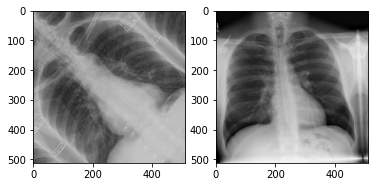

请多次运行此cell，观察ShiftScaleRotate函数的随机性对图片的作用，也可自行设置变换方法，观察变换方法的作用


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
from matplotlib import pyplot as plt
import albumentations as A
import numpy as np
import cv2


def transform_invert(img_, transform_train):
    """
    将data 进行反transfrom操作
    :param img_: tensor
    :param transform_train: torchvision.transforms
    :return: PIL image
    """
    if 'Normalize' in str(transform_train):
        norm_transform = list(filter(lambda x: isinstance(x, transforms.Normalize), transform_train.transforms))
        mean = torch.tensor(norm_transform[0].mean, dtype=img_.dtype, device=img_.device)
        std = torch.tensor(norm_transform[0].std, dtype=img_.dtype, device=img_.device)
        img_.mul_(std[:, None, None]).add_(mean[:, None, None])

    img_ = img_.transpose(0, 2).transpose(0, 1)  # C*H*W --> H*W*C
    if 'ToTensor' in str(transform_train) or img_.max() < 1:
        img_ = img_.detach().numpy() * 255

    if img_.shape[2] == 3:
        img_ = Image.fromarray(img_.astype('uint8')).convert('RGB')
    elif img_.shape[2] == 1:
        img_ = Image.fromarray(img_.astype('uint8').squeeze())
    else:
        raise Exception("Invalid img shape, expected 1 or 3 in axis 2, but got {}!".format(img_.shape[2]) )

    return img_

class COVID19Dataset(Dataset):
    def __init__(self, root_dir, txt_path, transform=None):
        """
        获取数据集的路径、预处理的方法
        """
        self.root_dir = root_dir
        self.txt_path = txt_path
        self.transform = transform
        self.img_info = []  # [(path, label), ... , ]
        self.label_array = None
        self._get_img_info()

    def __getitem__(self, index):
        """
        输入标量index, 从硬盘中读取数据，并预处理，to Tensor
        :param index:
        :return:
        """
        path_img, label = self.img_info[index]
        
        img_bgr = cv2.imread(path_img)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    

        if self.transform is not None:
            img = self.transform(image=img_rgb)

        return img, label

    def __len__(self):
        if len(self.img_info) == 0:
            raise Exception("\ndata_dir:{} is a empty dir! Please checkout your path to images!".format(
                self.root_dir))  # 代码具有友好的提示功能，便于debug
        return len(self.img_info)

    def _get_img_info(self):
        """
        实现数据集的读取，将硬盘中的数据路径，标签读取进来，存在一个list中
        path, label
        :return:
        """
        # 读取txt，解析txt
        with open(self.txt_path, "r") as f:
            txt_data = f.read().strip()
            txt_data = txt_data.split("\n")

        self.img_info = [(os.path.join(self.root_dir, i.split()[0]), int(i.split()[2]))
                         for i in txt_data]
        
# you can download the datasets from
# https://pan.baidu.com/s/18BsxploWR3pbybFtNsw5fA  code：pyto
root_dir = r"F:\pytorch-tutorial-2nd\data\datasets\covid-19-demo"  # path to datasets——covid-19-demo
img_dir = os.path.join(root_dir, "imgs")
path_txt_train = os.path.join(root_dir, "labels", "train.txt")

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=55, p=0.5),
    ]
)
train_data = COVID19Dataset(root_dir=img_dir, txt_path=path_txt_train, transform=train_transform)
train_loader = DataLoader(dataset=train_data, batch_size=2)
for data, labels in train_loader:
    print(data["image"].shape, labels)
    img_1 = data["image"][0]
    img_2 = data["image"][1]
    plt.subplot(121).imshow(img_1)
    plt.subplot(122).imshow(img_2)
    plt.show()
print("请多次运行此cell，观察ShiftScaleRotate函数的随机性对图片的作用，也可自行设置变换方法，观察变换方法的作用")

# dual transforms

图像标签对形式的数据增强  
这里以图像分割为例展示图像标签对的使用，与图像分类中不同之处只在于需要数据、标签同时出入transforms函数中，并且读取时依据key-value对进行读取。

In [50]:
def visualize(image, mask, original_image=None, original_mask=None):
    fontsize = 18
    if original_image is None and original_mask is None:
        f, ax = plt.subplots(2, 1, figsize=(8, 8))
        ax[0].imshow(image)
        ax[1].imshow(mask)
    else:
        f, ax = plt.subplots(2, 2, figsize=(8, 8))
        ax[0, 0].imshow(original_image)
        ax[0, 0].set_title('Original image', fontsize=fontsize)
        ax[1, 0].imshow(original_mask)
        ax[1, 0].set_title('Original mask', fontsize=fontsize)
        ax[0, 1].imshow(image)
        ax[0, 1].set_title('Transformed image', fontsize=fontsize)
        ax[1, 1].imshow(mask)
        ax[1, 1].set_title('Transformed mask', fontsize=fontsize)
    plt.show()

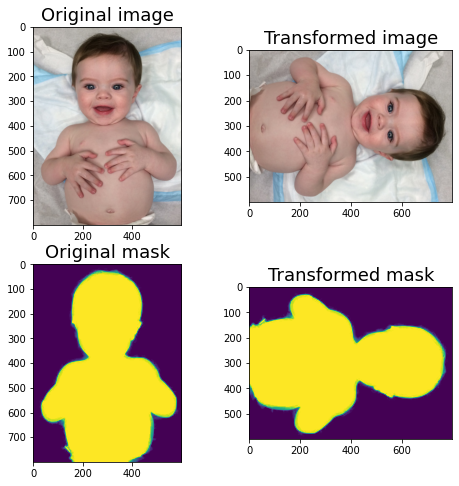

In [71]:
from albumentations import (
        HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
        Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
        IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
        IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, Flip, OneOf, Compose
    )

# download from :
# 链接：https://pan.baidu.com/s/1Kk4r0m0YFvB1iycyGI39Cg 
# 提取码：gmsr

path_img = r"F:\pytorch-tutorial-2nd\data\imgs\00016.png"
path_mask = r"F:\pytorch-tutorial-2nd\data\imgs\00016_matte.png"

image = cv2.imread(path_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path_mask, 0)

data_transform = A.Compose(
    [
        A.RandomRotate90(p=1),
        A.HueSaturationValue(p=0.5)
    ]
)

# 这一行模拟dataset中的 self.transform()
data_augmented = data_transform(image=image_rgb, mask=mask)

# 这一行模拟迭代训练中从DataLoader获取到的data
image_padded, mask_padded = data_augmented['image'], data_augmented['mask']

# 可视化
visualize(image_padded, mask_padded, original_image=image_rgb, original_mask=mask)


# 68个数据增强可视化

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


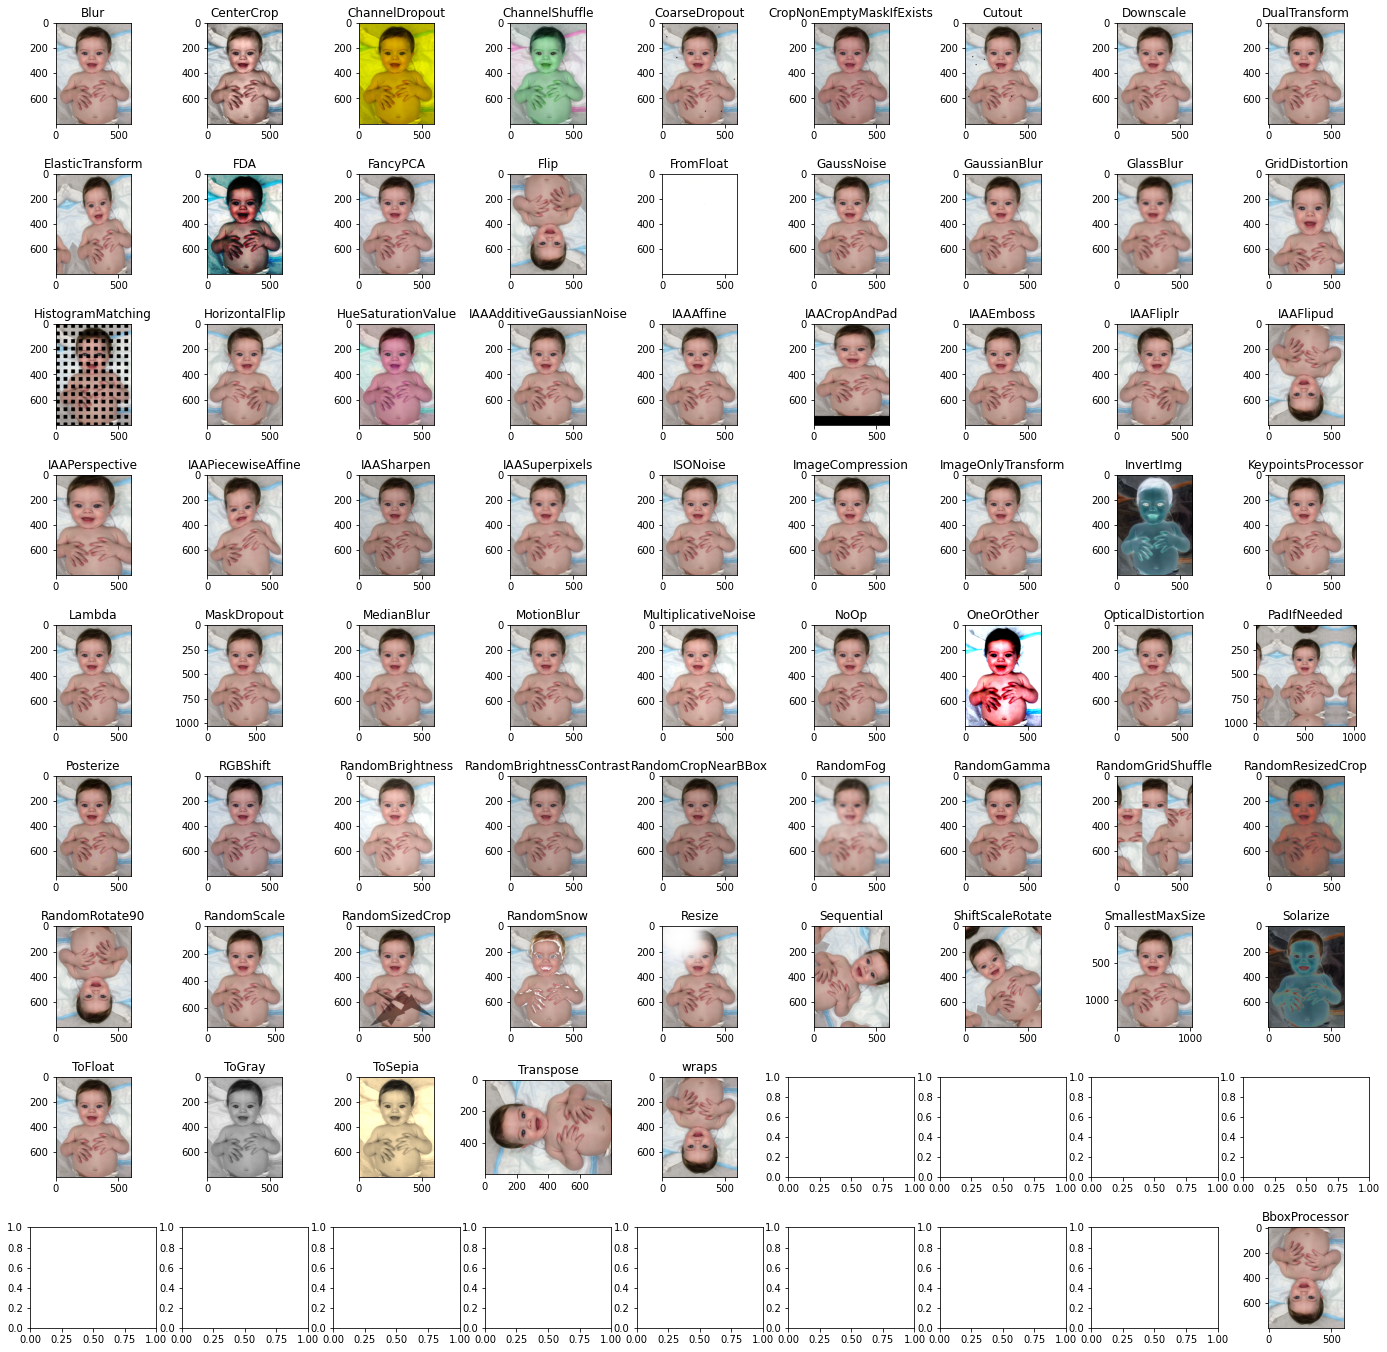

68


In [51]:
from importlib import import_module

# download from :
# 链接：https://pan.baidu.com/s/1Kk4r0m0YFvB1iycyGI39Cg 
# 提取码：gmsr
path_img = r"F:\pytorch-tutorial-2nd\data\imgs\00016.png"
path_mask = r"F:\pytorch-tutorial-2nd\data\imgs\00016_matte.png"

image = cv2.imread(path_img)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread(path_mask, 0)


A = import_module("albumentations")  # 虽复杂，但是是新知识点，保留作为学习资料

aug_list_cand = dir(A)
counter = 0

f, ax = plt.subplots(9, 9, figsize=(24, 24))
f.subplots_adjust(wspace=0.2,hspace=0.5)
for idx, aug_name in enumerate(aug_list_cand):
    try:
        data_transform = eval("A.{}".format(aug_name))(p=1)
        data_augmented = data_transform(image=image_rgb)
        image_aug = data_augmented['image']
        counter += 1
    except Exception as e:
        pass
    ax.ravel()[counter-1].imshow(image_aug)
    ax.ravel()[counter-1].set_title(aug_name)
# plt.savefig("aug_demo-68.png")
plt.show()
print(counter)
